<a href="https://colab.research.google.com/github/davidabelin/doubledigits/blob/main/arithmetic_double_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2018 Google LLC.

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Handwritten Digit Classification

In [ ]:
#@title IMPORTS
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sbn

import zipfile
import math
import random as rd
import numpy as np
import pandas as pd
import os, signal
from IPython.display import clear_output

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
#from tensorflow.keras.preprocessing.image import img_to_array, load_img
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, InputLayer, Input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam

## Construct the Input Data

In [ ]:
#Load
mnist = tf.keras.datasets.mnist
(imgs_train, ans_train), (imgs_test, ans_test) = mnist.load_data()

# Knobs
nrows = 2
ncols = 5

N = 10000 # num training examples
image_size = (28,56)

# Data
imgs_train.shape, imgs_test.shape

11493376/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), (10000, 28, 28))

In [ ]:
im = np.zeros(image_size)
left_index = rd.randint(0,len(ans_train)-1)   
right_index = rd.randint(0,len(ans_train)-1) 
for i in range(image_size[1]//2):
    im[:,i] = imgs_train[left_index,:,i]
    im[:,i+image_size[1]//2] = imgs_train[right_index,:,i]

maxswer = np.max([ans_train[left_index],ans_train[right_index]])
minswer = np.min([ans_train[left_index],ans_train[right_index]])
answer = maxswer*10 + minswer

print ("Answer:", maxswer,"* 10 +",minswer,"=",answer)

plt.imshow(im)

Add
[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.  98. 255.   0.   0.   0.   0.]
 [  0.   0.   0.   0.  89. 255.   0.   0.   0.   0.]
 [  0.   0.   0.   0.  82. 255.   0.   0.   0.   0.]
 [  0. 104. 104. 109. 110. 255. 103. 104. 103.   0.]
 [  0. 255. 255. 255.  96. 255. 255. 255. 255.   0.]
 [  0.  54.  48.  50. 104. 255.  36.  17.  15.   0.]
 [  0.   0.   0.   0.  82. 255.   0.   0.   0.   0.]
 [  0.   0.   0.   0. 110. 255.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]]


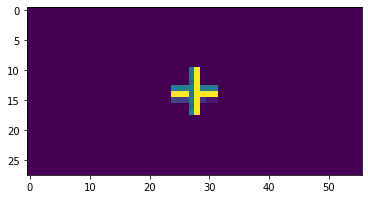

In [ ]:
def getOperator(image, operation):
    if operation == 'Multiply':     #MULTIPLY
        for row in range(11,18):
            image[28-row,row+14] = 255
            image[row,row+14] = 255
            image[row,row+15] /= 2
            image[row,row+15] += 255/row
            image[row,row+13] /= 2
            image[row,row+13] += 50 + 512/row
            image[28-row,row+13] /= 2
            image[28-row,row+13] += 100 + 255/(28-row)
            image[28-row,row+15] /= 2
            image[28-row,row+15] += 512/(28-row)
    else:
        if operation == 'Divide':       #DIVIDE
            for row in range(7,22):
                image[28-row,row+14] = 255
                image[28-row,row+13] /= 2
                image[28-row,row+13] += 60 + 255/row
                image[28-row,row+15] /= 2
                image[28-row,row+15] += 512/(28-row)
        else:
            image[14,24:32] = 255  # MINUS SIGN (FOR BOTH ADD AND SUB)
            #if (image[13,24:32] > 255-99).any():  
            #    image[13,24:32] /= 2
            image[13,24:32] += [rd.randint(77,111) for _ in range(8)]
            #if (image[15,25:31] > 255-33).any():
            #    image[15,25:31] /= 2
            image[15,24:32] += [rd.randint(11,55) for _ in range(8)]
        
            if operation == 'Add': 
                image[10:18,28] = 255
                #if (image[10:18,27] > 255-99).any():
                #    image[10:18,27] /= 2
                image[10:18,27] = [rd.randint(77,111) for _ in range(8)] # PLUS SIGN

    return image.clip(0,255)

op = rd.choice(['Add','Multiply','Subtract','Divide'])
image = getOperator(np.zeros((28,56)),op)
#(image[9:19,23:33] > 255).any()
print (op)
print(image[9:19,23:33])
plt.imshow(image)#[9:19,23:33])

In [ ]:
#from dd_convo
im = np.zeros((28,56))
tens_index = rd.randint(0,len(ans_train)-1)   
ones_index = rd.randint(0,len(ans_train)-1) 
for i in range(28):
    im[:,i] = imgs_train[tens_index,:,i]
    im[:,i+28] = imgs_train[ones_index,:,i]
answer = ans_train[tens_index]*10 + ans_train[ones_index]
print ("Answer =", ans_train[tens_index],"* 10 +",ans_train[ones_index],"=",answer)
plt.imshow(im)

In [ ]:
def doubleDigits(images=imgs_train,answers=ans_train,ops=True):

    image = np.zeros(image_size)
    left_index = rd.randint(0, len(answers)-1)   
    right_index = rd.randint(0, len(answers)-1)
    for i in range(28):                 # PUT IN THE DIGITS
        image[:,i] = images[left_index,:,i]
        image[:,i+28] = images[right_index,:,i]
    if ops:                           # MAKE ARITHMETIC SET
        operation =  rd.choice(['Add','Multiply','Subtract','Divide']) # TRUE+*  FALSE-/
        if operation == 'Add':                       #ADD
                answer = answers[left_index] + answers[right_index] 
        else: 
            if operation == 'Multiply':                   #MULTIPLY
                    answer = answers[left_index] * answers[right_index]
            else:               #SUBTRACT AND DIVIDE
                maxswer = np.max([answers[left_index],answers[right_index]])
                minswer = np.min([answers[left_index],answers[right_index]])
                if operation == 'Subtract':       #SUBTRACT
                    answer = maxswer - minswer
                else:                               #DIVIDE        
                    if answers[right_index] == 0:
                        answer = 99
                    else:
                        answer = int(answers[left_index] // answers[right_index])
        image = getOperator(image, operation)

    else:                # DOUBLE DIGITS BY DEFAULT
        answer = answers[left_index]*10 + answers[right_index]   

    return image, answer              
    #returns image array, list of answers
print("Loaded function doubleDigits.")

def getDoubleDigits(images=imgs_train,answers=ans_train,how_many=1,ops=True):
    yy = []
    xx = []
    for i in range(how_many):
        dd, ans = doubleDigits(images,answers,ops)
        yy += [ans]
        xx.append(dd)
        if i%500 == 0:
            print("Loaded:",i,"of",how_many,"examples...")
            clear_output(wait=True)
    print("Loaded:",how_many,"examples.")
    return xx, yy

print("Loaded function getDoubleDigits.")

Loaded function doubleDigits.
Loaded function getDoubleDigits.


Loaded: 1 examples.
Answer: 3


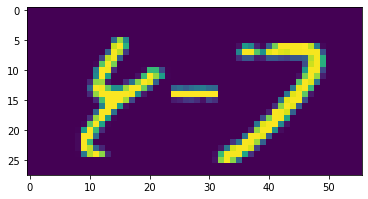

In [ ]:
# AND FINALLY CALL FUNCTION gDD TO SHOW AN EXAMPLE OF A 
# CONSTRUCTED IMAGE AND ANSWER TO MAKE SURE IT LOOKS OK
x, y = getDoubleDigits(imgs_test,ans_test,ops=True)
#print('~Random example~')
idx = rd.randint(0,len(y))
print('Answer:',y[idx])
plt.imshow(x[idx])

In [ ]:
N = 100000
######### GENERATE DD TRAINING DATA FOR FIRST MODEL #################
xts, y_test = getDoubleDigits(imgs_test,ans_test,N//20,ops=True)
x_test = np.array(xts) / 255.
print("Made",N//20,"new double-digit images to test on.")

xtn, y_train = getDoubleDigits(imgs_train,ans_train,N,ops=True)
x_train = np.array(xtn) / 255.
print("Made",N,"new double-digit images to train on.")

######################## Add a channels dimension
x_train = x_train[..., np.newaxis].astype("float32") #was tf.newaxis
x_test = x_test[..., np.newaxis].astype("float32")  #was tf.newaxis
#x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
#x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

####################### TF Datasets for input
train_ds = tf.data.Dataset.from_tensor_slices( (x_train, y_train) )
test_ds = tf.data.Dataset.from_tensor_slices( (x_test, y_test) )

Loaded: 100000 examples.
Made 100000 new double-digit images to train on.


# Build Convolutional NN

In [ ]:
###################### Build CNN as first model
input_layer = layers.Input(shape=(image_size[0], image_size[1], 1))

x = layers.Conv2D(20, 4, padding='same', activation='relu')(input_layer)
x = layers.Conv2D(20, 3, padding='same', activation='relu')(x) 
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(20, 2, padding='same', activation='relu')(x) 
x = layers.MaxPooling2D(2)(x)
x = layers.Flatten()(x)
#x = layers.Dropout(0.2)(x)
x = layers.Dense(500)(x)
x = layers.Dropout(0.2)(x)
output_layer = layers.Dense(100, activation='softmax')(x)
######################### 100 or else dict(list(set(y_train))!

####################### Build
model = Model(input_layer, output_layer)

####################### Compile
model.compile(loss="sparse_categorical_crossentropy",
              #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=Adam(lr=0.0025), #0.0075
              metrics=['acc'])
for layer in model.layers:
    layer.trainable = True
####################### Layer-outputs model
layer_outputs = [layer.output for layer in model.layers[1:]]
output_model = Model(input_layer, layer_outputs)

####################### History containers
answers, guesses = [],[]
model.summary()

### Training / Loading and reloading

In [ ]:
############################# Train the CNN first:
mhistory = model.fit(train_ds.shuffle(N+1).batch(N//100),
                     validation_data=test_ds.batch(N//200),  
                     epochs=10,  
                     verbose=1)

In [ ]:
##################### Put in a small NN at the end
for layer in model.layers:
    layer.trainable = False
    if "max_pooling2d_15" in layer.name: out_layer = layer.name

x = model.get_layer(out_layer).output
x = layers.Flatten()(x)
x = layers.Dense(100, activation='relu')(x)
x = layers.Dropout(0.2)(x)
new_output_layer = layers.Dense(100, activation='softmax')(x)
new_model = Model(input_layer, new_output_layer)
new_model.compile(loss="sparse_categorical_crossentropy",
              #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=Adam(lr=0.0025), #0.0075
              metrics=['acc'])

####################### Layer-outputs for new model
new_layer_outputs = [layer.output for layer in new_model.layers[1:]]
new_output_model = Model(input_layer, new_layer_outputs)

new_model.summary()

In [ ]:
#for layer in model.layers:
#    layer.trainable = True
for layer in new_model.layers:
    print (layer.trainable)

In [ ]:
############################# Train new_model
new_history = new_model.fit(train_ds.shuffle(N+1).batch(N//100),
                            validation_data=test_ds.batch(N//200),  
                            epochs=10,  
                            verbose=1)

In [ ]:
plotLearningCurves(new_history)

### Visualizing Intermediate Representations


In [ ]:
#@title Display learning curves 
def plotLearningCurves(history=mhistory):
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')

    #plt.figure()

    #plt.plot(epochs, loss)
    #plt.plot(epochs, val_loss)
    #plt.title('Training and validation loss')

plotLearningCurves()

In [ ]:
#@title Deprecated Functions NO_GUESSING() and NO_GET_RESULTS()
def no_guessing(N=1,model=model,X=False):
    answers, guesses = [],[]
    for count in range(N):
        if X:
            take1_ds = testX_ds.shuffle(10001).take(1)    
        else:
            take1_ds = test_ds.shuffle(10001).take(1)
        for img, ans in take1_ds:
            ans = ans.numpy()
            img = img.numpy()                  # 28x56x1
        img = img.reshape((1,) + img.shape)    # 1x28x56x1
        guess_set = model.predict(img)
        #guess = tf.random.categorical( guess_set, num_samples=1 ).numpy().squeeze()
        guess = np.argmax(guess_set)
        
        answers += [ans]
        guesses += [guess]
        #pG += [guess_set[guess]]
        #pA += [guess_set[answer]]
        #print("Answer",answer,"\tGuess",guess)#, "\tp(A)",pA,"\tp(G)",pG)
       
        if count%20 == 0:
            print ('Processing...',count,"...")
            clear_output(wait=True)

    return answers, guesses#, pA, pG

def no_get_results(N=1,m=model,X=False):
    no_results = pd.DataFrame(columns=['Answer','Guess'])#,'P(A)','P(G)'])
    no_results['Answer'], no_results['Guess'] = no_guessing(N, m, X) #, results['P(A)'], results['P(G)'] 
    return no_results

In [ ]:
#@title Functions GUESSING() and GET_RESULTS()
def guessing(n=1,model=model,return_image=False):
    answers, guesses, pA, pG = [],[],[],[]
    for count in range(n):
        take1_ds = test_ds.shuffle(N+1).take(1)
        for img, ans in take1_ds:
            ans = ans.numpy()
            img = img.numpy()                  # eg. 28x56x1
        img = img.reshape((1,) + img.shape)    # eg. 1x50x50x1
        guess_set = model.predict(img).flatten()
        #guess = tf.random.categorical( guess_set, num_samples=1 ).numpy().squeeze()
        guess = np.argmax(guess_set)
        
        answers += [ans]
        guesses += [guess]
        pG += [guess_set[guess]]
        pA += [guess_set[ans]]

        print("Answer",ans,"\tGuess",guess, "\tp(A)",round(pA[count],2),"\tp(G)",round(pG[count],2))
        if count%10 == 0:
            print ('Processing...',count,"...")
            clear_output(wait=True)

    if return_image:
        return answers, guesses, pA, pG, img
    else:
        return answers, guesses, pA, pG

def get_results(n=1,m=model):
    results = pd.DataFrame(columns=['Answer','Guess','P(A)','P(G)'])
    results['Answer'], results['Guess'], results['P(A)'], results['P(G)'] = guessing(n, m) 
    return results

In [ ]:
answers, guesses, pA, pG, img = guessing(1, return_image=True)
print (answers[0], guesses[0])
print (pA[0], pG[0])
plt.imshow(img[0,:,:,0])

In [ ]:
#@title Show layer output from first model...

# Take random image from the training set.
take1_ds = test_ds.shuffle(10001).take(1)
for img, ans in take1_ds:
    img = img.numpy()
    ans = ans.numpy()
img = img.reshape((1,) + img.shape)    # np shape (1, 28, 28, 1)
gue = model.predict(img)
print("Answer:",ans, "\tGuess:",np.argmax(gue))
plt.figure(figsize=(3,3))
plt.imshow(img[0,:,:,0])                 # np shape (28, 28)

layer_output_maps = output_model.predict( img )
layer_names = [layer.name for layer in model.layers[1:]]
for layer_name, layer_map in zip(layer_names, layer_output_maps):
    if len(layer_map.shape) == 4:# and not 'max_pooling' in layer_name:
        n_maps = layer_map.shape[-1]  # number of maps
        if n_maps > 10:
            n_maps = 10
        # Map has shape (1, rows, columns, n_features)
        rows = layer_map.shape[1]
        cols = layer_map.shape[2]
        image_grid = np.zeros((rows, cols * n_maps))
        
        for i in range(n_maps):
            x = layer_map[0, :, :, i]
            x *= 255.0
            image_grid[:, i * cols : (i + 1) * cols] = x
            image_grid[:,i*cols] = 255.
            image_grid[:,i*cols+1] = 0.
            
        scale = 2.           
        plt.figure(figsize=(scale * n_maps, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(image_grid, cmap='viridis')
 

In [ ]:
#@title Show layer output from "new model" with small NN

# Take random image from the training set.
take1_ds = test_ds.shuffle(10001).take(1)
for img, ans in take1_ds:
    img = img.numpy()
    ans = ans.numpy()
img = img.reshape((1,) + img.shape)    # np shape (1, 28, 28, 1)
gue = new_model.predict(img)
print("Answer:",ans, "\tGuess:",np.argmax(gue))
plt.figure(figsize=(3,3))
plt.imshow(img[0,:,:,0], cmap="binary_r")                 # np shape (28, 28)

layer_output_maps = new_output_model.predict( img )
layer_names = [layer.name for layer in new_model.layers[1:]]
for layer_name, layer_map in zip(layer_names, layer_output_maps):
    if len(layer_map.shape) == 4:# and not 'max_pooling' in layer_name:
        n_maps = layer_map.shape[-1]  # number of maps
        if n_maps > 10:
            n_maps = 10
        # Map has shape (1, rows, columns, n_features)
        rows = layer_map.shape[1]
        cols = layer_map.shape[2]
        image_grid = np.zeros((rows, cols * n_maps))
        
        for i in range(n_maps):
            x = layer_map[0, :, :, i]
            x *= 255.0
            image_grid[:, i * cols : (i + 1) * cols] = x
            image_grid[:,i*cols] = 255.
            image_grid[:,i*cols+1] = 0.
            
        scale = 2.           
        plt.figure(figsize=(scale * n_maps, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(image_grid, cmap='gray')
 

### examine results.

In [ ]:
results = get_results(100,new_model)
results

In [ ]:
tv = results['Guess'] == results['Answer']
wrongs = results.loc[~tv]
wrongs.sort_values('Answer')

#Build modelX

In [ ]:
######### GENERATE NEW TRAINING DATA  #################
######### usually no need to get more data! ###########
def get_new_data(n=N,ops=True):
    xts, y_testX = getDoubleDigits(images=imgs_test,
                                   answers=ans_test,
                                   how_many=n,
                                   ops=True)
    x_testX = np.array(xts) / 255.
    print("Made",n,"new images to test on.")

    xtn, y_trainX = getDoubleDigits(imgs_train,
                                    ans_train,
                                    n,
                                    ops=True)
    x_trainX = np.array(xtn) / 255.
    print("Made",n,"new images to train on.")

    print(len(set(y_trainX)),"unique labels:",set(y_trainX))

    ######################## Add a channels dimension
    x_trainX = x_trainX[..., tf.newaxis].astype("float32")
    x_testX = x_testX[..., tf.newaxis].astype("float32")

    ####################### TF Datasets for input
    trainX_ds = tf.data.Dataset.from_tensor_slices( (x_trainX, y_trainX) )
    testX_ds = tf.data.Dataset.from_tensor_slices( (x_testX, y_testX) )

    return x_trainX, y_trainX, x_testX, y_testX, trainX_ds, testX_ds

In [ ]:
#x_trainX, y_trainX, x_testX, y_testX, trainX_ds, testX_ds = get_new_data(n=N,X=True)
#x_trainX, y_trainX, x_testX, y_testX, trainX_ds, testX_ds = x_train, y_train, x_test, y_test, train_ds, test_ds

In [ ]:
plt.imshow(rd.choice(x_train)[:,:,0])

In [ ]:
###### ALTERNATIVE BUILD: NN MODEL ########### 


########################### This works ###########################
x = layers.Flatten()(input_layer)
x = layers.Dense(100, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(100, activation='relu')(x) 
x = layers.Dropout(0.1)(x)
output_layer = layers.Dense(100, activation='softmax')(x) 
modelX = Model(input_layer, output_layer)
########################### ^^^^^^^^^^ ###########################


####################### Compile
modelX.compile(loss="sparse_categorical_crossentropy",
              optimizer=Adam(lr=0.0075), #0.0025),
              metrics=['acc'])
    
####################### Layer-outputs model
layer_outputsX = [layer.output for layer in modelX.layers[1:]]
output_modelX = Model(input_layer, layer_outputsX)

####################### History containers
answersX, guessesX = [],[]

####################### Summary
#modelX.summary()
tf.keras.utils.plot_model(modelX,show_shapes=True)

In [ ]:
############################# Train modelX
historyX = modelX.fit(train_ds.shuffle(N+1).batch(N//100), 
                     epochs=20,  
                     validation_data=test_ds.batch(10), 
                     verbose=1)

In [ ]:
plotLearningCurves(historyX)

In [ ]:
#@title Show layer output from MODELX ...

# Take random image from the training set.
take1_ds = test_ds.shuffle(10001).take(1)
for img, ans in take1_ds:
    img = img.numpy()
    ans = ans.numpy()
img = img.reshape((1,) + img.shape)    # np shape (1, 28, 28, 1)
gue = modelX.predict(img)
print("Answer:",ans, "\tGuess:",np.argmax(gue))
plt.figure(figsize=(3,3))
plt.imshow(img[0,:,:,0])                 # np shape (28, 28)

layer_output_maps = output_modelX.predict( img )
layer_names = [layer.name for layer in modelX.layers[1:]]
for layer_name, layer_map in zip(layer_names, layer_output_maps):
    if "flatten" in layer_name: 
        layer_map = layer_map.reshape(1,image_size[0],image_size[1])
        n_maps = layer_map.shape[0]  # 1 = number of maps

        # Map has shape (1, rows, columns)
        #rows = layer_map.shape[1]
        #cols = layer_map.shape[2]
        #image_grid = np.zeros((rows, cols))
        
        #for i in range(n_maps):
        x = layer_map[0, :, :]
        #x *= 255.0
        #image_grid[:, cols : 2 * cols] = x
            
        scale = 2.           
        plt.figure(figsize=(scale * n_maps, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(x)  #(image_grid, cmap='viridis')

In [ ]:
layer_output_maps = output_modelX.predict( img )
layer_names = [layer.name for layer in modelX.layers[1:]]
for layer_name, layer_map in zip(layer_names, layer_output_maps):
    if "flatten" in layer_name:#len(layer_map.shape) == 4:# and not 'max_pooling' in layer_name:
         layer_map = layer_map.reshape(1,28,56)
    print (layer_name, layer_map.shape)

In [ ]:
####################### Layer-outputs model
#layer_outputsX = [layer.output for layer in modelX.layers[1:]]
#output_modelX = Model(input_layer, layer_outputsX)
modelX_neurons = output_modelX.variables[0].numpy().T
modelX_neurons_df = pd.DataFrame(modelX_neurons)
neuronX_df = pd.DataFrame(modelX_neurons[2].reshape((28,56)))
#neuronX_df              

In [ ]:
plt.imshow(neuronX_df)

In [ ]:
    #  x -= x.mean()
    #  x /= x.std()
    #  x *= 64
    #  x += 128
    #  x = np.clip(x, 0, 255).astype('uint8')
    #  x /= 255
    
nxmin = min(neuronX_df.min())
nxmax = max(neuronX_df.max())
nxmean = np.mean(neuronX_df.mean())
nxstd = np.mean(neuronX_df.std())
print (nxmin,nxmax,nxmean,nxstd)
print ("nxmin*255, nxmax*255", nxmin*255, nxmax*255)

#neuronX_df *= 255.
neuronX_df += nxstd
neuronX_df.clip(0,nxmax)
#neuronX_df *= 255

plt.imshow(neuronX_df)

In [ ]:
modelX.variables[0].shape

In [ ]:
variablesX = modelX.variables[0].numpy()
(vmin,vmax,vmean,vstd) = (variablesX.min(), variablesX.max(), variablesX.mean(), variablesX.std())
(vmin,vmax,vmean,vstd)

In [ ]:
variablesX = np.clip((variablesX + abs(vstd))*255,0,255)
variablesX

In [ ]:
variables = modelX.variables[0].numpy()
num_nodes = variables.shape[1]
num_rows = int(math.ceil(num_nodes / 10.0))
fig, axes = plt.subplots(num_rows, 10, figsize=(40, 2 * num_rows))
for coef, ax in zip(variables.T, axes.ravel()):
    # Weights in coef is reshaped from 1x784 to 28x28.
    coef = coef
    ax.matshow(coef.reshape(image_size), cmap=plt.cm.viridis)
    ax.set_xticks(())
    ax.set_yticks(())
plt.show()

In [ ]:
resultsX = get_results(100, modelX)
resultsX

In [ ]:
plt.scatter(results['Guess'],results['Answer'])
plt.scatter(resultsX['Guess'],resultsX['Answer'])

In [ ]:
tvX = resultsX['Guess'] == resultsX['Answer']
wrongsX = resultsX.loc[~tvX]
#wrongsX.shape#, 
wrongsX.sort_values('Answer')

In [ ]:
# "one shot iterator"

answers, guesses, pA, pG, img = guessing(1, model=modelX, return_image=True)
print ("Label:", answers[0], "\tPredict:", guesses[0])
print ("pLabel =",pA[0], "\tpPredict = ", pG[0])
plt.imshow(img[0,:,:,0],cmap="gray")

In [ ]:
def showWeights():
    weights0 = modelX.weights[0].numpy()
    num_nodes = weights0.shape[1]
    num_rows = int(math.ceil(num_nodes / 10.0))
    fig, axes = plt.subplots(num_rows, 10, figsize=(40, 2 * num_rows))
    for coef, ax in zip(weights0.T, axes.ravel()):
        # Weights in coef is reshaped from 1x784 to 28x28.
        ax.matshow(coef.reshape(image_size), cmap=plt.cm.bone)
        ax.set_xticks(())
        ax.set_yticks(())
    plt.show()

In [ ]:
showWeights()

In [ ]:
#dense0 = pd.DataFrame(modelX.variables[0].numpy().T)
#d0_neurons = np.zeros((100,28,56))
#for i in range(dense0.shape[0]):
#    d0_neurons[i] = np.reshape(list(dense0.iloc[i]),image_size)
#plt.imshow(d0_neurons[7])